### Getting Ready

In [1]:
import sys

import diffusers
import matplotlib.pyplot as plt
import torch
import transformers
from IPython.display import display
from PIL import Image
from torchinfo import summary
from tqdm.notebook import tqdm

We'll print out version numbers of the critical packages, to help with future reproducibility.

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("diffusers version:", diffusers.__version__)
print("transformers version:", transformers.__version__)
print("torch version:", torch.__version__)
print("PIL version:", Image.__version__)

Platform: linux
Python version: 3.11.0 (main, Nov 15 2022, 20:12:54) [GCC 10.2.1 20210110]
---
diffusers version: 0.32.2
transformers version: 4.49.0
torch version: 2.2.2+cu121
PIL version: 10.2.0


Let's check if a GPU is available.  If not, this notebook will take a long time to run!  If a GPU is available, we'll use the "half-precision" `float16` data type.  This speeds up calculations, but isn't available on standard CPUs.  On those, we'll use the standard precision `float32` type.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(f"Using {device} device with {dtype} data type.")

Using cuda device with torch.float16 data type.


### Create Text Embeddings

Stable Diffusion attempts to produce an image aligned to a text description.  We're going to start by working on that text description.  We need to convert the human-readable text into an *embedding*.  This means that the text will be represented by a bunch of numbers, which the model will be able to ingest.

Stable diffusion uses text embeddings from the Contrastive Language-Image Pre-Training (CLIP) model.  We need two pieces from this model.  First, the tokenizer splits up a string into tokens, a word, part of a word, or single character.  We load only this component by specifying the `subfolder` argument.

In [4]:
tokenizer = transformers.CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="tokenizer",
    torch_dtype=dtype
)

print(tokenizer)

CLIPTokenizer(name_or_path='CompVis/stable-diffusion-v1-4', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)


In [5]:
type(tokenizer)

transformers.models.clip.tokenization_clip.CLIPTokenizer

**Task 6.2.1:** Call `tokenizer` with the text `"Hello, world!"` as an argument. Examine the return value.

In [6]:
text = "Hello, world!"
result = tokenizer(text)

print(type(result))
print(result)

<class 'transformers.tokenization_utils_base.BatchEncoding'>
{'input_ids': [49406, 3306, 267, 1002, 256, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1]}


This displays a common behavior of the transformers and diffusers libraries: they return custom containers with their results.  We can access elements of these containers ...

... indexing by key:

In [7]:
result["input_ids"]

[49406, 3306, 267, 1002, 256, 49407]

... or with an attribute name:

In [8]:
result.input_ids

[49406, 3306, 267, 1002, 256, 49407]

The `input_ids` attribute contains the list of tokens that the string was split into.  These tokens are represented by ID numbers.  You can find the string for a given token ID number with the `tokenizer.decode` method.

**Task 6.2.2:** Call `tokenizer.decode` on each of the token IDs in `result.input_ids`.

In [9]:
for token in result.input_ids:
    print(tokenizer.decode(token))

<|startoftext|>
hello
,
world
!
<|endoftext|>


Note that, in addition to words, there are tokens representing punctuation and the start and end of the text.

For our first image from Stable Diffusion, we're going to use the following prompt.

In [10]:
prompt = "A red bird flies through a blue sky over a green tree."

We need to tokenize it, but we'll do two things differently:
- We'll fix the number of output tokens.
- We'll have it return a PyTorch tensor instead of a Python list.

In [11]:
text_tokens = tokenizer(
    prompt,
    padding="max_length",  # Give us as many tokens as the model can handle.
    truncation=True,  # Truncate the output if it would give us more tokens.
    return_tensors="pt",  # Return a PyTorch tensor.
)

print(text_tokens.input_ids)
print(text_tokens.input_ids.shape)

tensor([[49406,   320,   736,  3329,  8070,  1417,   320,  1746,  2390,   962,
           320,  1901,  2677,   269, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])
torch.Size([1, 77])


Stable Diffusion works with a model *conditioned* on our text.  For this to work, we need an *unconditioned* result to compare to.  For this, we'll use the empty string.

**Task 6.2.3:** Create tokens for the empty string input.  Assign these to `uncond_token`.

In [12]:
uncond_tokens = tokenizer(
    "",
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

print(uncond_tokens.input_ids)
print(uncond_tokens.input_ids.shape)

tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])
torch.Size([1, 77])


These tokens will be converted into a text embedding with the `text_encoder` component.

In [13]:
embedder = transformers.CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder",
    torch_dtype=dtype
)
embedder.to(device)  # Do this on the GPU

# Print out a summary of this neural network
summary(embedder)

Layer (type:depth-idx)                                       Param #
CLIPTextModel                                                --
├─CLIPTextTransformer: 1-1                                   --
│    └─CLIPTextEmbeddings: 2-1                               --
│    │    └─Embedding: 3-1                                   37,945,344
│    │    └─Embedding: 3-2                                   59,136
│    └─CLIPEncoder: 2-2                                      --
│    │    └─ModuleList: 3-3                                  85,054,464
│    └─LayerNorm: 2-3                                        1,536
Total params: 123,060,480
Trainable params: 123,060,480
Non-trainable params: 0

We call it with the token IDs to generate the embedding.

In [14]:
with torch.no_grad():  # No need for gradient calculations
    text_embedding = embedder(text_tokens.input_ids.to(device))

print(type(text_embedding))
print(text_embedding.keys())

<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
odict_keys(['last_hidden_state', 'pooler_output'])


The embedding that we want is the `last_hidden_state` attribute.

**Task 6.2.4:** Determine the class and shape of the `last_hidden_state` attribute.

In [15]:
print("Class:", type(text_embedding.last_hidden_state))
print("Shape:", text_embedding.last_hidden_state.shape)

Class: <class 'torch.Tensor'>
Shape: torch.Size([1, 77, 768])


Evidently, each token has been mapped into a 768-dimension vector.

**Task 6.2.5:** Compute the embedding for the unconditioned tokens.

In [16]:
with torch.no_grad():
    uncond_embedding = embedder(uncond_tokens.input_ids.to(device))

print(uncond_embedding.last_hidden_state.shape)

torch.Size([1, 77, 768])


**Task 6.2.6:** Concatenate the unconditioned embedding followed by the text embedding into a tensor called `all_embeddings`.  (This will be convenient for a later step.)  You'll find `torch.cat` useful here.

In [17]:
all_embeddings = torch.cat(
    [uncond_embedding.last_hidden_state, text_embedding.last_hidden_state]
)

print(all_embeddings.shape)

torch.Size([2, 77, 768])


Now that these text embeddings are ready, we're going to set them aside for a bit.  Don't worry&mdash;we'll come back to them.

### Generate Random Latent Vectors

Stable Diffusion uses a *Variational Auto-Encoder* (*VAE*) to generate images from *latent vectors*.  At this point, we'll just create some random latent vectors.  We'll improve them in a later stage.

Let's load in the VAE model. Again, we specify this through the `subfolder` argument.

In [18]:
vae = diffusers.AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="vae",
    torch_dtype=dtype
)
vae.to(device)  # Run it on the GPU

summary(vae)

Layer (type:depth-idx)                             Param #
AutoencoderKL                                      --
├─Encoder: 1-1                                     --
│    └─Conv2d: 2-1                                 3,584
│    └─ModuleList: 2-2                             --
│    │    └─DownEncoderBlock2D: 3-1                738,944
│    │    └─DownEncoderBlock2D: 3-2                2,690,304
│    │    └─DownEncoderBlock2D: 3-3                10,754,560
│    │    └─DownEncoderBlock2D: 3-4                9,443,328
│    └─UNetMidBlock2D: 2-3                         --
│    │    └─ModuleList: 3-5                        1,051,648
│    │    └─ModuleList: 3-6                        9,443,328
│    └─GroupNorm: 2-4                              1,024
│    └─SiLU: 2-5                                   --
│    └─Conv2d: 2-6                                 36,872
├─Decoder: 1-2                                     --
│    └─Conv2d: 2-7                                 18,944
│    └─ModuleList: 2-8

This VAE is constructed mainly of convolutional layers, and it's able to produce outputs of various sizes.  We'll aim to produce 512$\times$512 images.

In [19]:
height = 512
width = 512

The encoder will downscale both the width and height by a factor of 8.  The decoder will upscale by the same factor.

In [20]:
scale_factor = 8

The number of channels in the latent vector is stored in the configuration:

In [21]:
n_channels = vae.config.latent_channels
print(n_channels)

4


Latent vectors will be a 4-D tensor, representing (batch, channel, height, width).  Don't be confused by the fact that there happen to be four channels.  That is a complete coincidence.

**Task 6.2.7:** Fill in the correct shape for a latent vector below.  It should have a batch size of 1 and appropriate dimensions to produce a 512$\times$512 image. The call to `torch.randn` will generate a random latent vector of that size.

In [22]:
latent_shape = (
    1, # Batch size
    n_channels, # Latent channels
    height // scale_factor, # Height
    width // scale_factor, # Width
)

random_latents = torch.randn(latent_shape, device=device, dtype=dtype)

print(random_latents.shape)

torch.Size([1, 4, 64, 64])


Since there are four channels, we can't visualize the latent vectors as an RGB image.  This function will plot each channel separately.

In [23]:
def plot_latents(latents):
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(latents[0, i].cpu().numpy())
        plt.colorbar()

**Task 6.2.8:** Plot the random latent vector.  If it's random, it should resemble static.

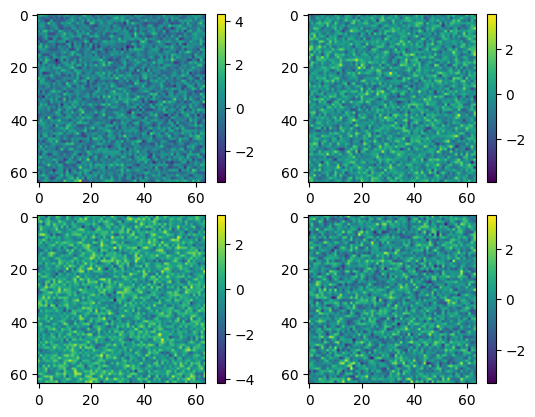

In [24]:
# Plot the latent vector
plot_latents(random_latents)

The following cell will use the VAE's decoder to convert the latent vectors into an image.

In [25]:
latents = random_latents
# Decode the latents
with torch.no_grad():
    scaling_factor = torch.tensor(vae.config.scaling_factor, device=device, dtype=dtype)
    decoded = vae.decode(latents / scaling_factor).sample

**Task 6.2.9:** Check the shape of the `decoded` tensor.

In [26]:
type(decoded)

torch.Tensor

In [27]:
print("Shape:", decoded.shape)

Shape: torch.Size([1, 3, 512, 512])


This is in (batch, channels, height, width) format.  However, PIL expects images in (height, width, channels) format.  We can use the `.permute()` method to switch things around.  We'll also convert the tensor into a NumPy array.

In [28]:
# Permute the dimensions and convert to NumPy
unscaled = decoded.permute(0, 2, 3, 1).cpu().numpy()
print("Shape:", unscaled.shape)

Shape: (1, 512, 512, 3)


**Task 6.2.10:** Plot a histogram of the values in this array.  This will help us understand the distribution of these values.

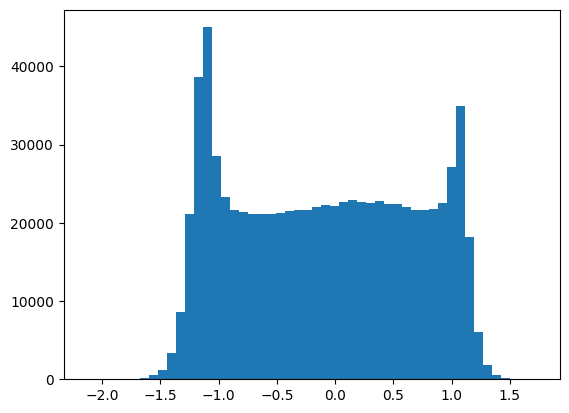

In [29]:
plt.hist(
    unscaled.flatten(),
    bins=50,
);

This shows us that most of the values are in the range [-1, 1].  We'll scale this to the range [0, 255].  Values that start outside of this range will be clipped to the min or max.  We'll also convert the datatype to the unsigned 8-bit integer type commonly used for images.

In [30]:
# Scale the image values to be between 0 and 255
scaled = ((unscaled + 1) * 255 / 2).clip(0, 255).round().astype("uint8")

**Task 6.2.11:** Create a PIL image and display it.  You'll find `Image.fromarray()` useful.

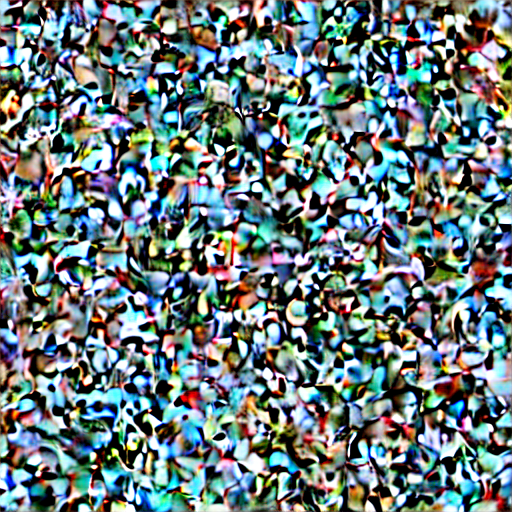

In [31]:
# Create a PIL image
Image.fromarray(scaled[0])

This does not look like anything in particular, because we started with a random latent vector.  But it also does not look like noise, because the latent space encodes common patterns.  We're seeing a random superposition of these common patterns.

**Task 6.2.12:** Create a function that returns the image corresponding to a latent vector.  We'll use this as we evolve the latent vectors later.  You should be able to complete this function by copying code from the previous cells.

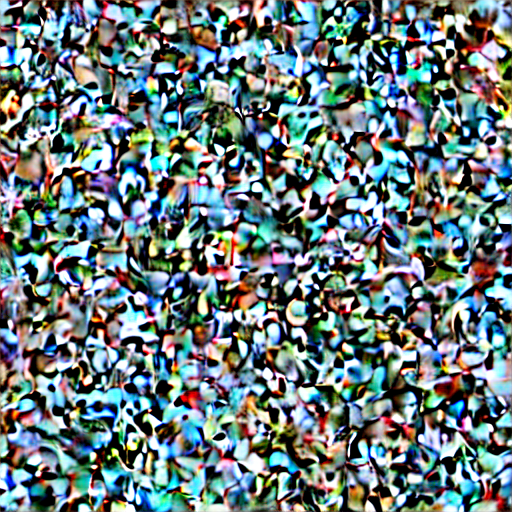

In [32]:
def latents_to_image(latents, vae=vae):
    """Transform the latent vector to a image, using a VAE decoder.

    Inputs:  latents  Latent vector(s) as a 4-D PyTorch tensor.  Only
                      the first element of the batch will be used.
             vae      The VAE used to decode the image from latents.

    Outputs: A PIL image corresponding to the latents.
    """
    # Scaling factor
    scaling_factor = torch.tensor(vae.config.scaling_factor, device=device, dtype=dtype)
    
    # Decode the latents
    with torch.no_grad():
         decoded = vae.decode(latents / scaling_factor).sample
    # Permute the dimensions and convert to NumPy
    unscaled = decoded.permute(0, 2, 3, 1).cpu().numpy()
    # Scale the image values to be between 0 and 255
    scaled = ((unscaled + 1) * 255 / 2).clip(0, 255).round().astype("uint8")
    # Return a PIL image
    return Image.fromarray(scaled[0])

latents_to_image(random_latents)

### Denoising Diffusion

This image above looks nothing like our prompt, but that's to be expected.  We created it from a random latent vector.  Our next task is to perform denoising diffusion on our latent vector.

To do this, we need two more components.  First, we need a model to predict the noise in our latent vector.  For that, we use a *U-Net* model.  These are similar to the ResNet models commonly used for image analysis.  This particular model is a *condition* model.  This mean that it can take our text embedding as input, to judge how well the denoised image matches the text.

In [33]:
unet = diffusers.UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet",
    torch_dtype=torch.float16
)
unet.to(device)

summary(unet)

Layer (type:depth-idx)                                            Param #
UNet2DConditionModel                                              --
├─Conv2d: 1-1                                                     11,840
├─Timesteps: 1-2                                                  --
├─TimestepEmbedding: 1-3                                          --
│    └─Linear: 2-1                                                410,880
│    └─SiLU: 2-2                                                  --
│    └─Linear: 2-3                                                1,639,680
├─ModuleList: 1-4                                                 --
│    └─CrossAttnDownBlock2D: 2-4                                  --
│    │    └─ModuleList: 3-1                                       5,092,480
│    │    └─ModuleList: 3-2                                       4,510,080
│    │    └─ModuleList: 3-3                                       921,920
│    └─CrossAttnDownBlock2D: 2-5                               

As we'll see, this process works best when done in a number of small steps. (This is because the U-Net model is trained in a series of steps that progressively add more noise.)  The *scheduler* will govern this process.

In [34]:
scheduler = diffusers.UniPCMultistepScheduler.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="scheduler"
)

print(scheduler)

UniPCMultistepScheduler {
  "_class_name": "UniPCMultistepScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "disable_corrector": [],
  "dynamic_thresholding_ratio": 0.995,
  "final_sigmas_type": "zero",
  "flow_shift": 1.0,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "predict_x0": true,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_p": null,
  "solver_type": "bh2",
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_flow_sigmas": false,
  "use_karras_sigmas": false
}



We should start by scaling our random latent vectors by the scheduler's `init_noise_sigma` factor.

**Task 6.2.13:** Create a starting latent vector by multiplying `random_latents` by the scheduler's `init_noise_sigma`.

In [35]:
latents = random_latents * scheduler.init_noise_sigma

latents.shape

torch.Size([1, 4, 64, 64])

In [37]:
scheduler.init_noise_sigma

1.0

<div class="alert alert-info" role="alert">
If you happened to check, you notice that <code>scheduler.init_noise_sigma</code> is actually 1.0.  The scaling didn't actually do anything in this case.  But other schedulers may have different values here, so we'll keep this step.
</div>

For our first demonstration we'll only do a single denoising step.  Setting this causes the scheduler to compute a tensor of time steps for denoising.

In [36]:
scheduler.set_timesteps(1)
print("Steps:", scheduler.timesteps)

Steps: tensor([999])


**Task 6.2.14:** Get the value of the first (and only) time step in the variable `t`.

In [38]:
t = scheduler.timesteps[0]

print(t)

tensor(999)


We'll need to run the denoising model twice, once with the unconditioned input and once with the conditioned text input.  We can be more efficient by doing them together in a batch of two.

**Task 6.2.15:** Create a `latent_inputs` tensor with two copies of `latents`.  It should be 2$\times$4$\times$64$\times$64.  You'll probably find `torch.cat` helpful.

In [39]:
# Assemble the latent inputs
latent_inputs = torch.cat([latents, latents])

print(latent_inputs.shape)

torch.Size([2, 4, 64, 64])


The following cell will make a prediction of the noise.  Since `all_embeddings` contains both the unconditioned and conditioned text embeddings (in that order), we'll get noise estimates for both.

In [40]:
# Predict the noise
scaled_inputs = scheduler.scale_model_input(latent_inputs, timestep=t)
with torch.no_grad():
    noise = unet(scaled_inputs, t, encoder_hidden_states=all_embeddings)

# Split the unconditioned and conditioned predictions
noise_uncond, noise_cond = noise.sample.chunk(2)

We combine these two estimates together.  The `guidance_scale` tells us how closely we should follow the prompt's conditioning.  Small values increase creativity, at the cost of not following the prompt too closely. Large values keep the image closer to the prompt, but increase the risk of artifacts.  Typical values run from 2 (lots of freedom) to 15 (follows prompt carefully).

In [41]:
guidance_scale = 7.5  # A pretty middle-of-the-road value
noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)

print(noise_pred.shape)

torch.Size([1, 4, 64, 64])


**Task 6.2.16:** Plot the predicted noise.  It's the same shape as the latent vector, so you can use the `plot_latents` function.

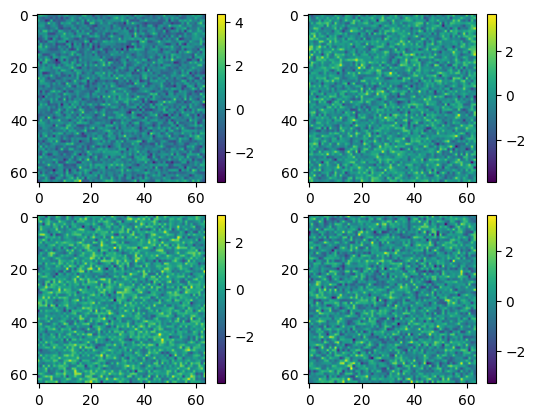

In [42]:
# Plot the noise prediction with `plot_latents`
plot_latents(noise_pred)

Now we can remove this predicted noise from the latent vector with the scheduler's `.step` method.

In [43]:
# Update the variable `latents` based on the predicted noise
latents = scheduler.step(noise_pred, t, latents).prev_sample

**Task 6.2.17:** Plot the denoised latent vector.

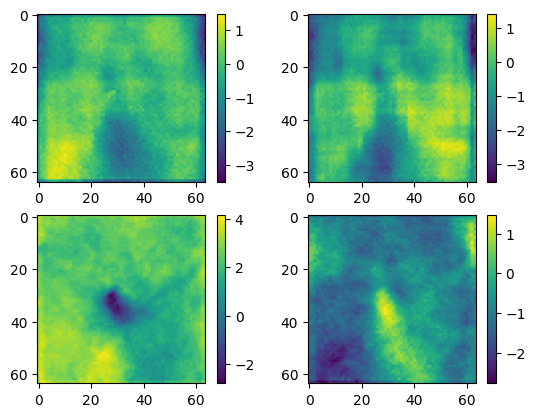

In [44]:
# Plot the latent vector with `plot_latents`
plot_latents(latents)

**Task 6.2.18:** Convert the latent vector to an image and display it.  Remember the `latents_to_image` function.

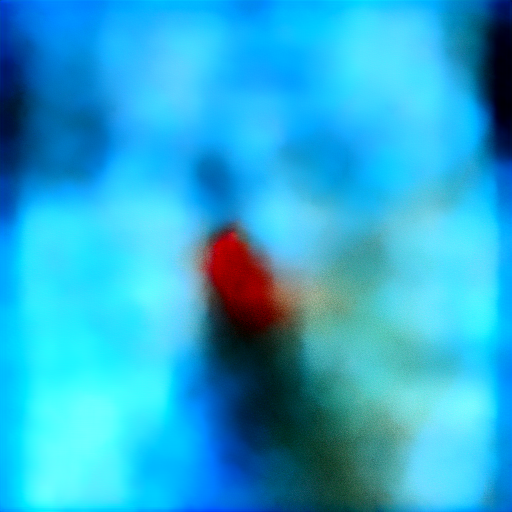

In [45]:
# Decode the latent vector to an image
latents_to_image(latents)

<div class="alert alert-info" role="alert">
Since we're starting with a random latent vector, we'll get a different image each time we run this notebook.
</div>

If you squint, you can sort of see a red bird, green tree, and blue sky.  We'll get much better results if we do more denoising steps.

**Task 6.2.19:** Set up a loop to run the denoising process over 50 steps.  We've provided code that will display the image at every step.  It will look like noise at the beginning, and tends to coalesce only at the very end.  You should be able to complete this code by copying sections of the previous code cells.

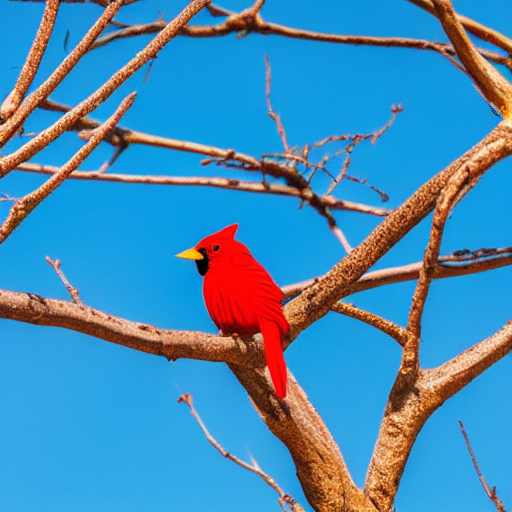

  0%|          | 0/50 [00:00<?, ?it/s]

In [46]:
num_steps = 50  # A typical number.  Increase for cleaner results.
scheduler.set_timesteps(num_steps)

# We'll start with the same random latent values as before.
latents = random_latents * scheduler.init_noise_sigma

# This will let us update the image through the training.
display_handle = display(latents_to_image(latents, vae), display_id="latent_display")

with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        # Assemble the latent inputs
        latent_inputs = torch.cat([latents, latents])
        # Predict the noise
        scaled_inputs = scheduler.scale_model_input(latent_inputs, timestep=t)
        with torch.no_grad():
            noise = unet(scaled_inputs, t, encoder_hidden_states=all_embeddings)

        # Split the unconditioned and conditioned predictions
        noise_uncond, noise_cond = noise.sample.chunk(2)
        # Combine the predictions according to the guidance scale
        noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
        # Update the variable `latents` based on the predicted noise
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        # This will update the image based on the current latent vector.
        display_handle.update(latents_to_image(latents, vae))

You've made it! You've successfully prompted the diffusion model to generate an image.

Next, we'll see how to use Pipelines to automate the whole process. You'll need to switch to the next notebook named `062-diffusion-pipelines.ipynb`.

But before doing so! Please STOP this notebook, so you free up the GPU VRAM allocated. In other case, you won't be able to run the Pipeline (there won't be enough VRAM available).

To stop this notebook, click on the Stop symbol at the top:

![](stop-notebook.png)

or execute the next cell that has `exit()` in it.

In [47]:
exit()